<a id="imports"></a>

<strong><h1>Imports</h1></strong>

In [93]:
import pandas as pd
from wordcloud import WordCloud
import seaborn as sns
import re
import string
from collections import Counter, defaultdict

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt



In [94]:
import warnings
warnings.filterwarnings('ignore')

In [95]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords_nltk = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a id="helper_functions"></a>

<strong><h1>Helper Functions</h1></strong>

In [96]:
import re
from typing import Union, List

class CleanText():
    """ clearing text except digits () . , word character """ 

    def __init__(self, clean_pattern = r"[^A-ZĞÜŞİÖÇIa-zğüı'şöç0-9.\"',()]"):
        self.clean_pattern =clean_pattern

    def __call__(self, text: Union[str, list]) -> List[List[str]]:

        if isinstance(text, str):
            docs = [[text]]

        if isinstance(text, list):
            docs = text

        text = [[re.sub(self.clean_pattern, " ", sent) for sent in sents] for sents in docs]

        return text
    
def remove_emoji(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def tokenize(text):
    """ basic tokenize method with word character, non word character and digits """
    text = re.sub(r" +", " ", str(text))
    text = re.split(r"(\d+|[a-zA-ZğüşıöçĞÜŞİÖÇ]+|\W)", text)
    text = list(filter(lambda x: x != '' and x != ' ', text))
    sent_tokenized = ' '.join(text)
    return sent_tokenized

regex = re.compile('[%s]' % re.escape(string.punctuation))

def remove_punct(text):
    text = regex.sub(" ", text)
    return text

clean = CleanText()


In [97]:
# label encode
def label_encode(x):
    if x == 1 or x == 2:
        return 0
    if x == 3:
        return 1
    if x == 5 or x == 4:
        return 2
    
# label to name
def label2name(x):
    if x == 0:
        return "Negative"
    if x == 1:
        return "Neutral"
    if x == 2:
        return "Positive"
    

<a id="read_data"></a>

<strong><h1>Read Data</h1></strong>

In [98]:
df = pd.read_csv("tripadvisor_hotel_reviews.csv")

In [99]:
# show column names
print("df.columns: ", df.columns) 

df.columns:  Index(['Review', 'Rating'], dtype='object')


In [100]:
# head of df
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [101]:
# count of ratings
fig = px.histogram(df,
             x = 'Rating',
             title = 'Histogram of Review Rating',
             template = 'ggplot2',
             color = 'Rating',
             color_discrete_sequence= px.colors.sequential.Blues_r,
             opacity = 0.8,
             height = 525,
             width = 835,
            )

fig.update_yaxes(title='Count')
fig.show()

In [102]:
# basic info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [103]:
# encode label and mapping label name
df["label"] = df["Rating"].apply(lambda x: label_encode(x))
df["label_name"] = df["label"].apply(lambda x: label2name(x))

In [104]:
# clean text, lowercase and remove punk
df["Review"] = df["Review"].apply(lambda x: remove_punct(clean(remove_emoji(x).lower())[0][0]))

In [105]:
df.head()

,Review,Rating,label,label_name
0,nice hotel expensive parking got good deal sta...,4,2,Positive
1,ok nothing special charge diamond member hilto...,2,0,Negative
2,nice rooms not 4 experience hotel monaco seat...,3,1,Neutral
3,unique great stay wonderful time hotel monac...,5,2,Positive
4,great stay great stay went seahawk game aweso...,5,2,Positive


In [106]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=200,
        max_font_size=40, 
        scale=1,
        random_state=1
).generate(" ".join(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

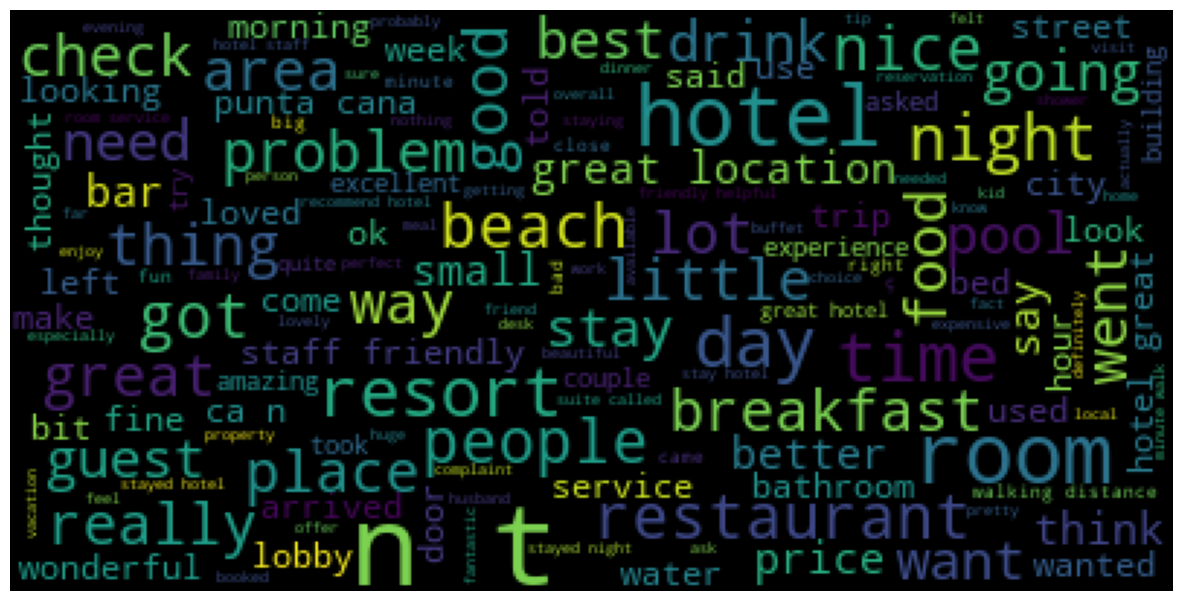

In [107]:
show_wordcloud(df["Review"].values)

In [108]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "bar"}]])
colors = ['gold', 'mediumturquoise', 'lightgreen'] # darkorange
fig.add_trace(go.Pie(labels=df.label_name.value_counts().index,
                             values=df.label.value_counts().values), 1, 1)

fig.update_traces(hoverinfo='label+percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.add_trace(go.Bar(x=df.label_name.value_counts().index, y=df.label.value_counts().values, marker_color = colors), 1,2)

fig.show()


In [109]:
# tokenize data
df["tokenized_review"] = df.Review.apply(lambda x: tokenize(x))
# calculate token count for any sent
df["sent_token_length"] = df["tokenized_review"].apply(lambda x: len(x.split()))

In [110]:
fig = px.histogram(df, x="sent_token_length", nbins=20, color_discrete_sequence=px.colors.cmocean.algae, barmode='group', histnorm="percent")
fig.show()

In [111]:
(df.sent_token_length < 512).mean()

0.989117173393197

In [112]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [113]:
# data tokenize with bert tokenizer
df["sent_bert_token_length"] = df["Review"].apply(lambda x: len(tokenizer(x, add_special_tokens=False)["input_ids"]))

Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors


In [114]:
fig = px.histogram(df, x="sent_token_length", nbins=20, color_discrete_sequence=px.colors.cmocean.algae, barmode='group', histnorm="percent")
fig.show()

In [115]:
# Less than 512 covers how many of the data
(df.sent_bert_token_length < 512).mean()


0.9853106241764678

In [116]:
# valvulate char count for each review
df['char_count'] = df['Review'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 )
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))


    plt.suptitle(f'{title}', fontsize=24)

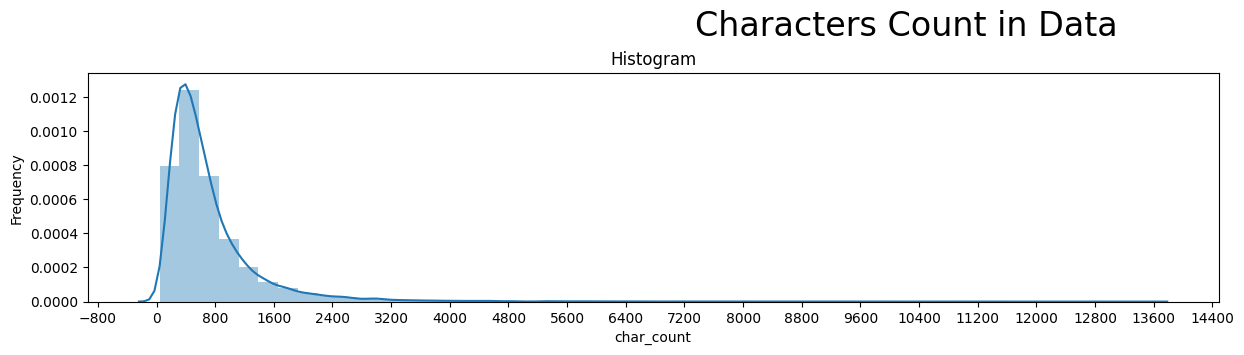

In [117]:
plot_dist3(df, 'char_count',
           'Characters Count in Data')

In [118]:
# Creating a new feature for the visualization.
df['Character Count'] = df['Review'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(24, 12))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    plt.suptitle(f'{title}', fontsize=24)

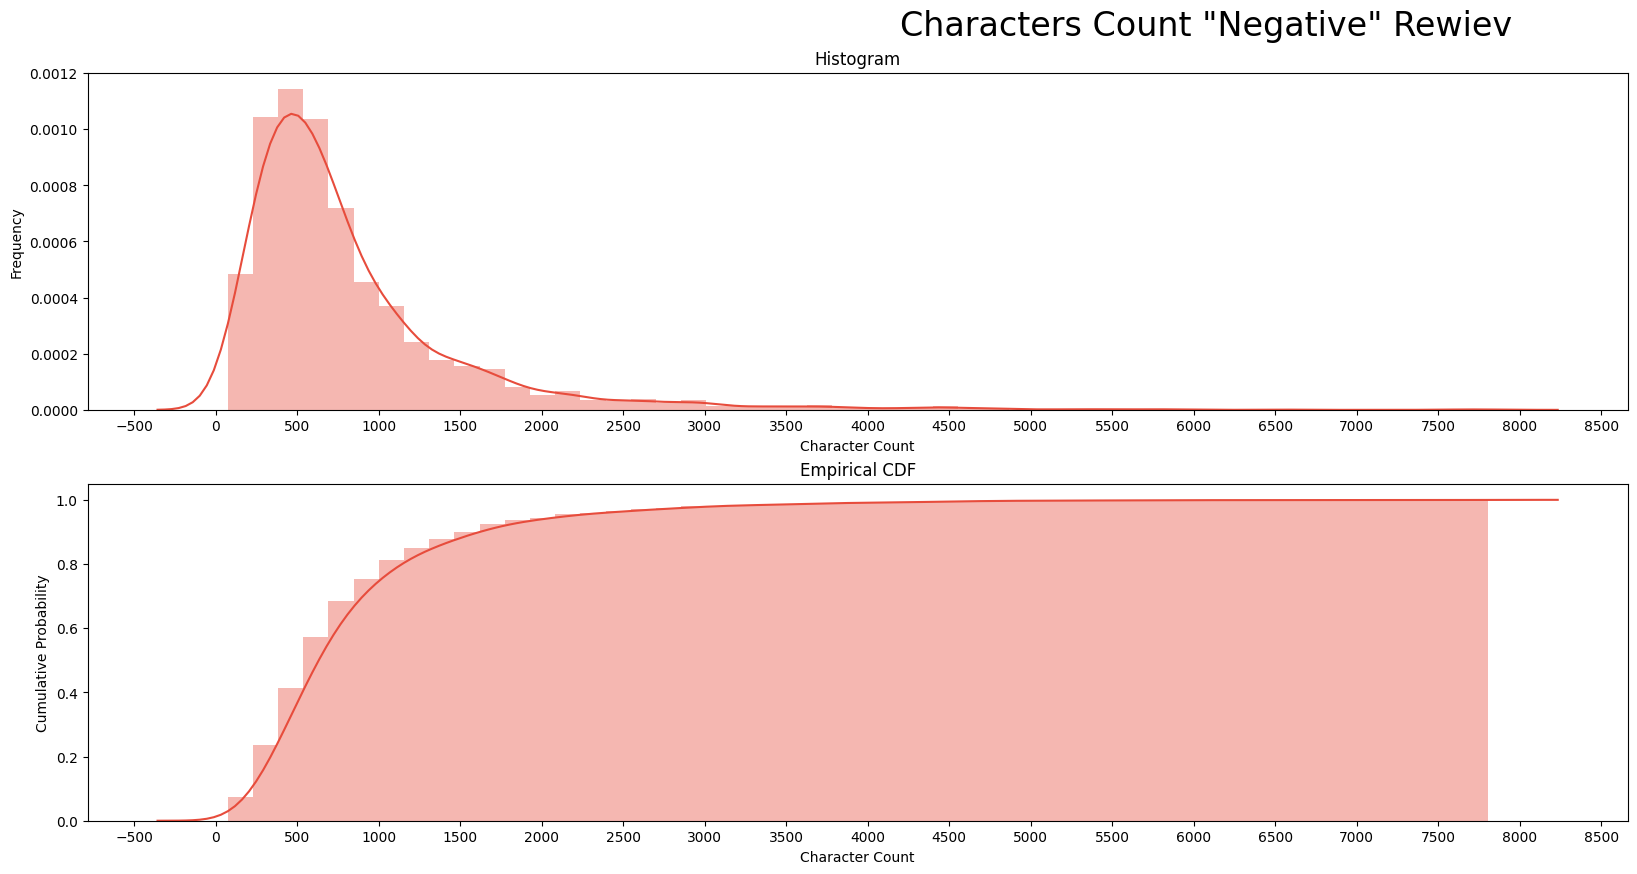

In [119]:
plot_dist3(df[df['label'] == 0], 'Character Count',
           'Characters Count "Negative" Rewiev')

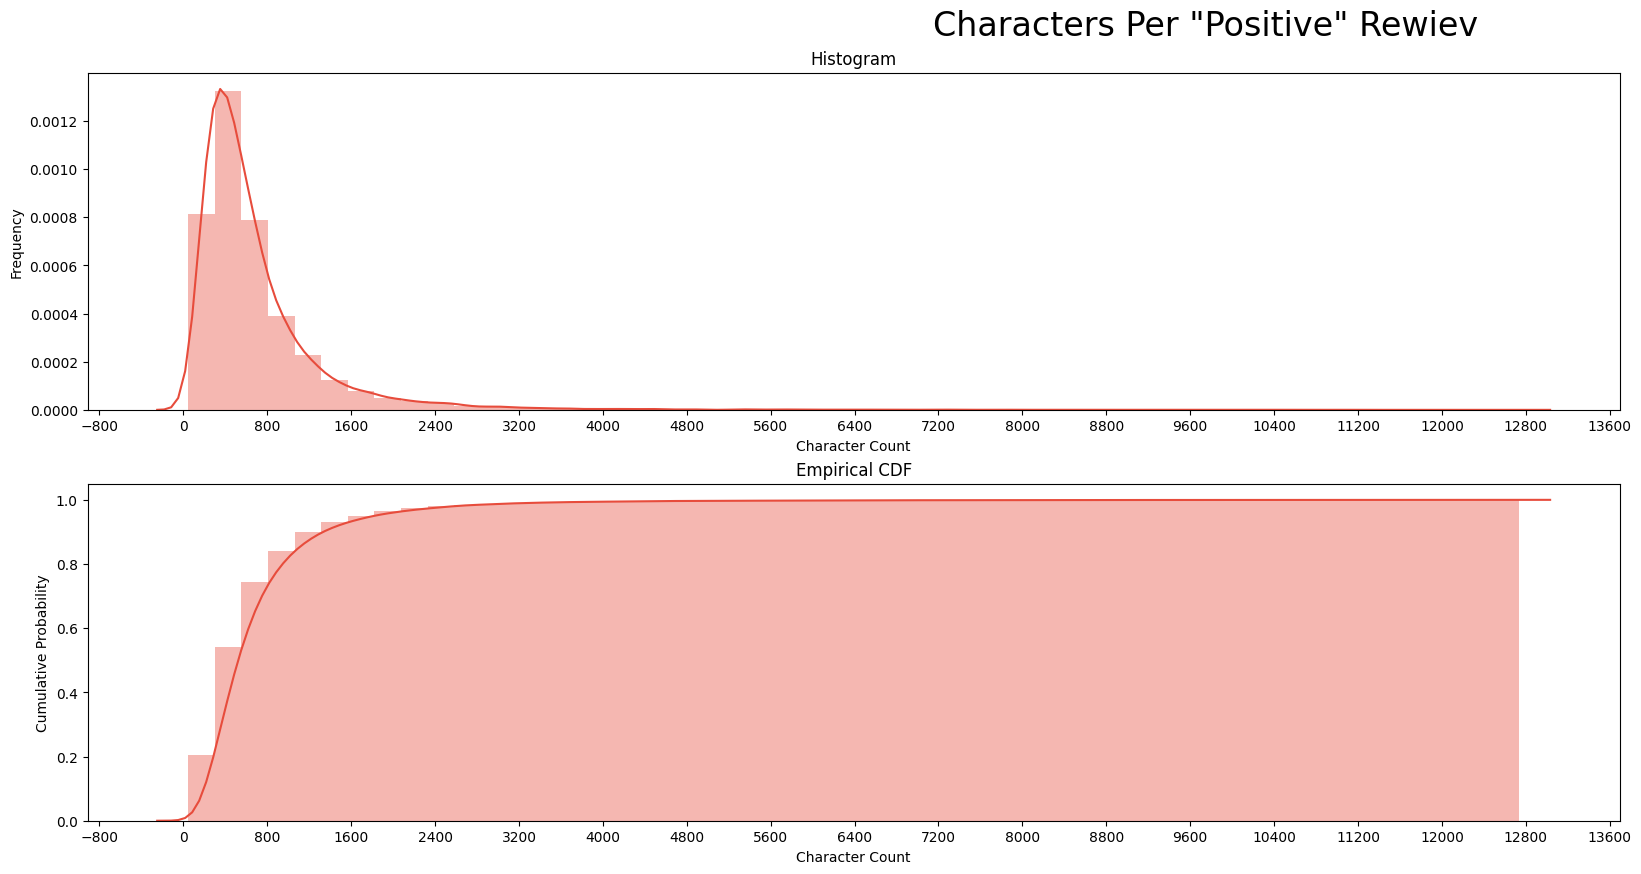

In [120]:
plot_dist3(df[df['label'] == 2], 'Character Count',
           'Characters Per "Positive" Rewiev')

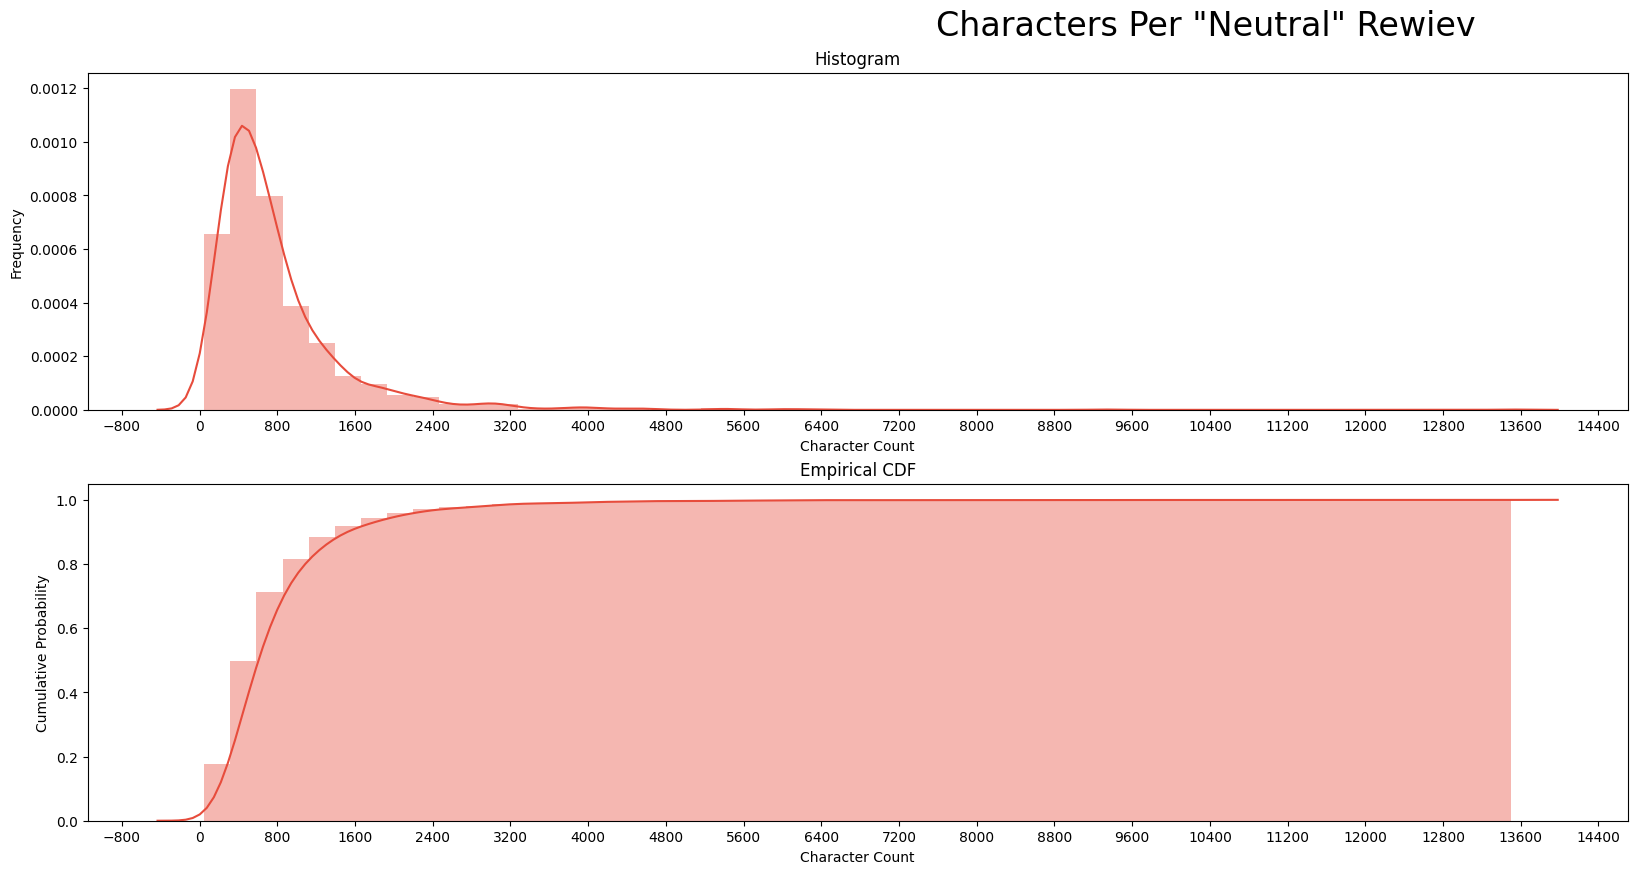

In [121]:
plot_dist3(df[df['label'] == 1], 'Character Count',
           'Characters Per "Neutral" Rewiev')

<a id="word_counts"></a>

## Word Counts

We see that the situation in the number of characters and the situation in the number of words are the same. We have seen that people use less word count when expressing negative things.

In [122]:
def plot_word_number_histogram(textno, textye, textz):
    
    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(18, 12), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')
    sns.distplot(textz.str.split().map(lambda x: len(x)), ax=axes[2], color='#e74c3c')

    
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('negative')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('netrual')
    axes[2].set_xlabel('Word Count')
    axes[2].set_title('pozitive')
    
    fig.suptitle('Words Per Review', fontsize=24, va='baseline')
    
    fig.tight_layout()

Exception ignored in: <function tqdm.__del__ at 0x0000020F9C396840>
Traceback (most recent call last):
  File "c:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x0000020F9C396840>
Traceback (most recent call last):
  File "c:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <funct

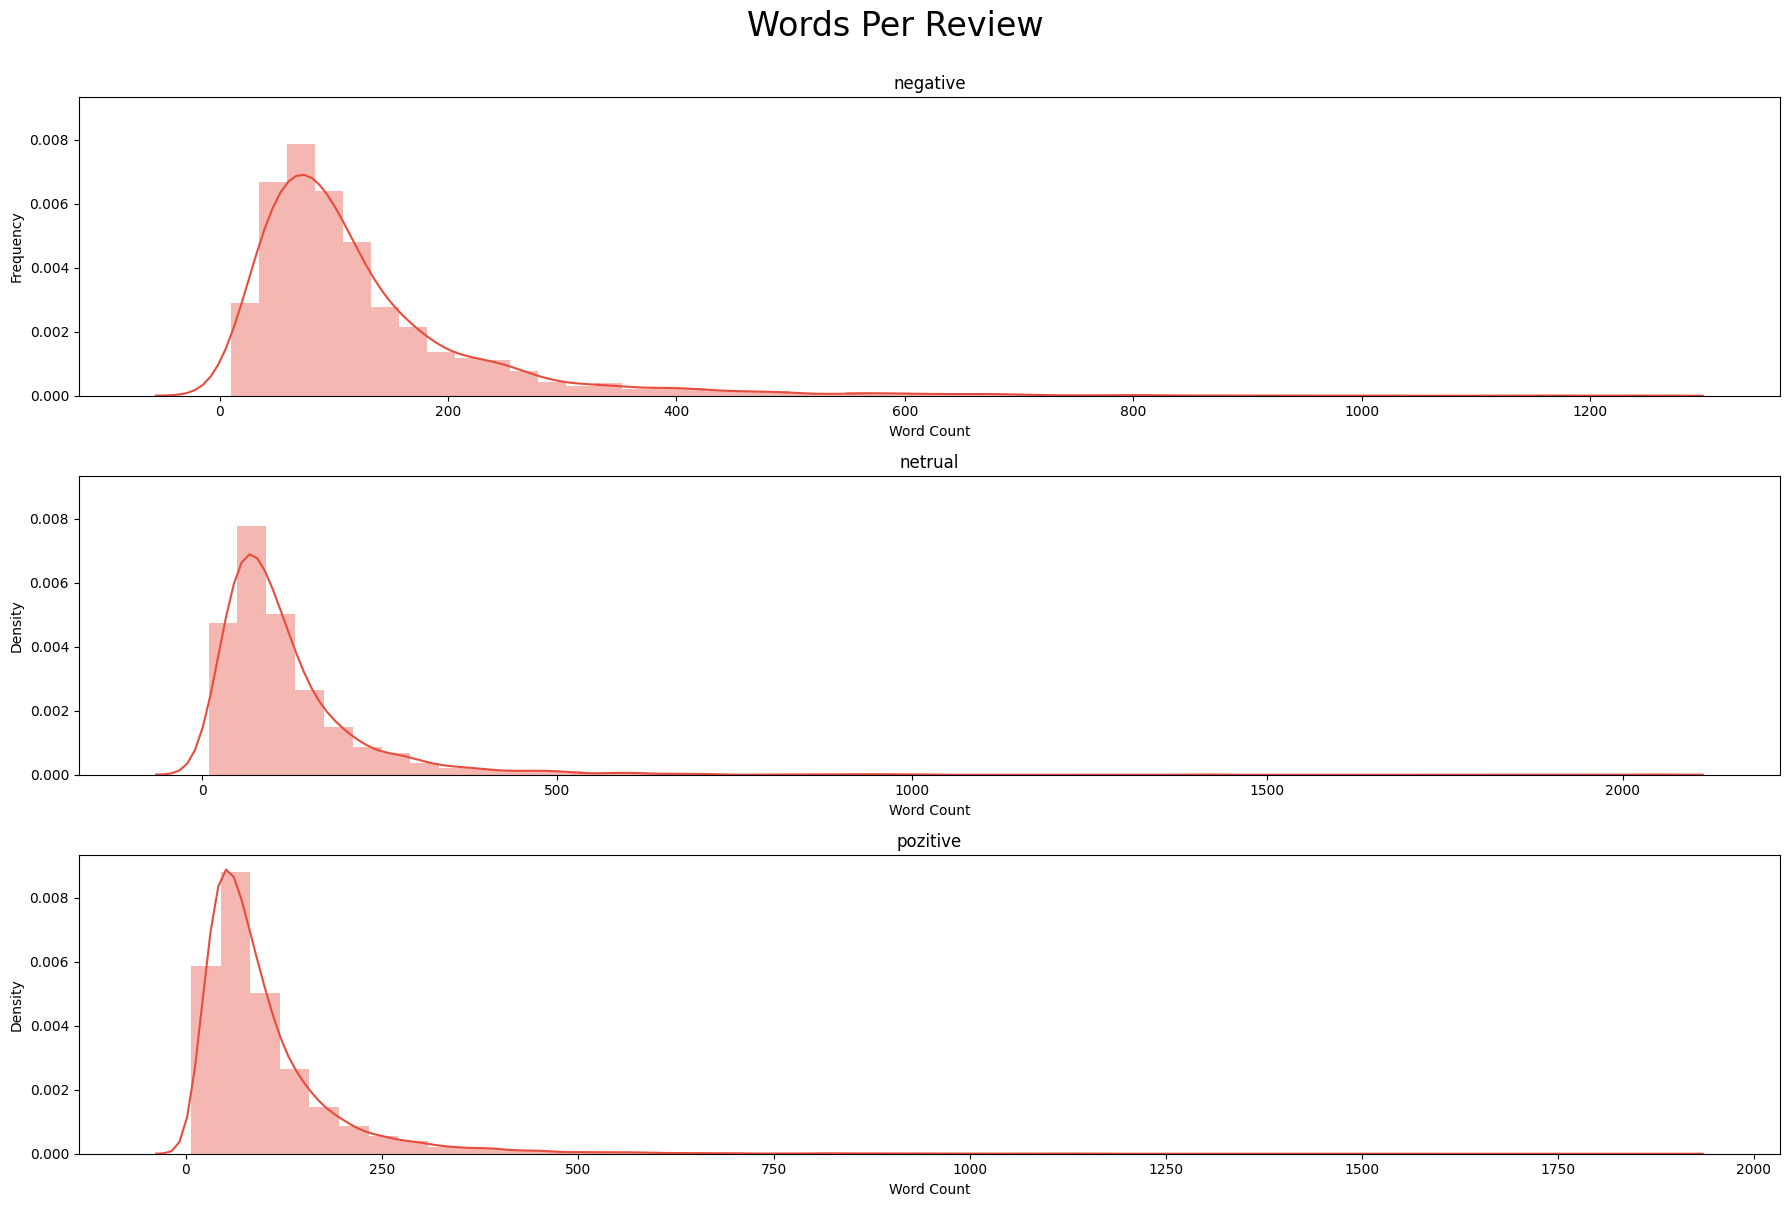

In [123]:
plot_word_number_histogram(df[df['label'] == 0]['Review'],
                           df[df['label'] == 1]['Review'],
                           df[df['label'] == 2]['Review'],
                          )

In [124]:
# remove punk 
df['tokenized_review'] = df['tokenized_review'].apply(lambda x: remove_punct(x))


<a id="most_common_words"></a>
## Most Common Words

In [125]:
texts = df['tokenized_review']
new = texts.str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:30]:
    if word not in stopWords_nltk:
        x.append(word)
        y.append(count)

fig = go.Figure(go.Bar(
            x=y,
            y=x,
            orientation='h',  marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Most common Word',))

fig.update_layout( title={
        'text': "Most Common Words",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))

fig.show()

<a id="most_common_ngrams"></a>

## Most Common ngrams

In [126]:
fig = make_subplots(rows=1, cols=3)
title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = df[df["label"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []

    for word, count in most[:30]:
        if word not in stopWords_nltk:
            x.append(word)
            y.append(count)

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)
    
fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common ngrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ),)


fig.show()

In [127]:
def _get_top_ngram(corpus, n=None):
    #getting top ngrams
    vec = CountVectorizer(ngram_range=(n, n),
                          max_df=0.9,
                          ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:15]

In [128]:
# unigram
fig = make_subplots(rows=1, cols=3)

title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = df[df["label"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    top_n_bigrams = _get_top_ngram(texts, 2)[:15]
    x, y = map(list, zip(*top_n_bigrams))


    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)
    

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common unigrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))      
fig.show()

In [129]:
#trigram

fig = make_subplots(rows=1, cols=3)
title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = df[df["label"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    top_n_bigrams = _get_top_ngram(texts, 3)[:15]
    x, y = map(list, zip(*top_n_bigrams))

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1),

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common trigrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))
    
fig.show()

**We examined and visualized the data, now we can move on to the model building part.**

<a id="models"></a>
<strong><center><h1><div class="top_section">3. MODELS</div></h1></center></strong>


<a id="preprocess_for_BERT_Train"></a>

<strong><h1>Preprocess for BERT Train</h1></strong>

In [130]:
import pandas as pd
import numpy as np
import os
import random
from pathlib import Path
import json

In [131]:
import torch
from tqdm.auto import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [132]:
class Config():
    seed_val = 17
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    epochs = 5 
    batch_size = 6
    seq_length = 512
    lr = 2e-5
    eps = 1e-8
    pretrained_model = 'bert-base-uncased'
    test_size=0.15
    random_state=42
    add_special_tokens=True 
    return_attention_mask=True 
    pad_to_max_length=True 
    do_lower_case=False
    return_tensors='pt'

config = Config()

In [133]:
# params will be saved after training
params = {"seed_val": config.seed_val,
    "device":str(config.device),
    "epochs":config.epochs, 
    "batch_size":config.batch_size,
    "seq_length":config.seq_length,
    "lr":config.lr,
    "eps":config.eps,
    "pretrained_model": config.pretrained_model,
    "test_size":config.test_size,
    "random_state":config.random_state,
    "add_special_tokens":config.add_special_tokens,
    "return_attention_mask":config.return_attention_mask,
    "pad_to_max_length":config.pad_to_max_length,
    "do_lower_case":config.do_lower_case,
    "return_tensors":config.return_tensors,
         }

In [134]:
# set random seed and device
import random

device = config.device

random.seed(config.seed_val)
np.random.seed(config.seed_val)
torch.manual_seed(config.seed_val)
torch.cuda.manual_seed_all(config.seed_val)

In [135]:
df.head()

,Review,Rating,label,label_name,tokenized_review,sent_token_length,sent_bert_token_length,char_count,Character Count
0,nice hotel expensive parking got good deal sta...,4,2,Positive,nice hotel expensive parking got good deal sta...,88,91,593,593
1,ok nothing special charge diamond member hilto...,2,0,Negative,ok nothing special charge diamond member hilto...,258,268,1689,1689
2,nice rooms not 4 experience hotel monaco seat...,3,1,Neutral,nice rooms not 4 experience hotel monaco seatt...,237,273,1427,1427
3,unique great stay wonderful time hotel monac...,5,2,Positive,unique great stay wonderful time hotel monaco ...,92,102,600,600
4,great stay great stay went seahawk game aweso...,5,2,Positive,great stay great stay went seahawk game awesom...,197,213,1281,1281


<a id="Train_and_Validation_Split"></a>
<strong><h2>Train and Validation Split</h2></strong>


In [136]:
#split train test
from sklearn.model_selection import train_test_split

train_df_, val_df = train_test_split(df, 
                                    test_size=0.10, 
                                    random_state=config.random_state, 
                            stratify=df.label.values)

In [137]:
train_df_.head()

,Review,Rating,label,label_name,tokenized_review,sent_token_length,sent_bert_token_length,char_count,Character Count
8159,central simple 4 nights bbvery small room no a...,3,1,Neutral,central simple 4 nights bbvery small room no a...,27,37,208,208
15738,stay stayed flight cancelled stranded 3 days ...,5,2,Positive,stay stayed flight cancelled stranded 3 days a...,75,87,487,487
9972,n t want stay picked hotel du candran excellen...,5,2,Positive,n t want stay picked hotel du candran excellen...,142,162,902,902
7265,best deal town reserved internet months advanc...,5,2,Positive,best deal town reserved internet months advanc...,48,48,353,353
8747,nice place wife arrived usa 10am offered choic...,4,2,Positive,nice place wife arrived usa 10 am offered choi...,86,91,579,579


In [138]:
train_df, test_df = train_test_split(train_df_, 
                                    test_size=0.10, 
                                    random_state=42, 
                            stratify=train_df_.label.values)

In [139]:
# count of unique label  control 
print(len(train_df['label'].unique()))
print(train_df.shape)

3
(16596, 9)


In [140]:
# count of unique label  control 
print(len(val_df['label'].unique()))
print(val_df.shape)

3
(2050, 9)


In [141]:
print(len(test_df['label'].unique()))
print(test_df.shape)

3
(1845, 9)


<a id="BertTokenizer_and_Encoding_the1_Data"></a>

<strong><h2>BertTokenizer and Encoding the Data</h2></strong>

In [142]:
# create tokenizer
tokenizer = BertTokenizer.from_pretrained(config.pretrained_model, 
                                          do_lower_case=config.do_lower_case)

In [143]:
encoded_data_train = tokenizer.batch_encode_plus(
    train_df.Review.values, 
    add_special_tokens=config.add_special_tokens, 
    return_attention_mask=config.return_attention_mask, 
    pad_to_max_length=config.pad_to_max_length, 
    max_length=config.seq_length, 
    return_tensors=config.return_tensors
)
encoded_data_val = tokenizer.batch_encode_plus(
    val_df.Review.values, 
    add_special_tokens=config.add_special_tokens, 
    return_attention_mask=config.return_attention_mask, 
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length, 
    return_tensors=config.return_tensors
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [144]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_df.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val_df.label.values)

In [145]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

<a id="Creating_the_Model"></a>

<strong><h2>Creating the Model</h2></strong>

In [147]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=config.batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=config.batch_size)

<a id="Optimizer_Scheduler"></a>

<strong><h2>Optimizer & Scheduler</h2></strong>

In [148]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=config.lr, 
                  eps=config.eps)
                  

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*config.epochs)

<a id="Performance_Metrics"></a>
<strong><h2>Performance Metrics</h2></strong>

We will use f1 score  as performance metrics.

In [149]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

<a id="Training_Loop"></a>
<strong><h2>Training Loop</h2></strong>

In [150]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(config.device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        
    # calculate avareage val loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [151]:
config.device

device(type='cuda', index=0)

In [152]:
model.to(config.device)
    
for epoch in tqdm(range(1, config.epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    # allows you to see the progress of the training 
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(config.device) for b in batch)
        
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    
    tqdm.write(f'F1 Score (Weighted): {val_f1}');
# save model params and other configs 
with Path('params.json').open("w") as f:
    json.dump(params, f, ensure_ascii=False, indent=4)

  0%|          | 0/5 [00:00<?, ?it/s]

<a id="Test"></a>
<strong><h2>Test on validation set</h2></strong>

In [ ]:
model.load_state_dict(torch.load(f'./_BERT_epoch_3.model', map_location=torch.device('cpu')))

In [ ]:
from sklearn.metrics import classification_report

preds_flat = np.argmax(predictions, axis=1).flatten()
print(classification_report(preds_flat, true_vals))

<a id="error_analysis"></a>

<strong><center><h1><div class="top_section">4. ERROR ANALYSIS</div></h1></center></strong>


In [ ]:
# step by step predictions on dataframe
# We do this to view predictions in the pandas dataframe and easily filter them and perform error analysis.

pred_final = []

for i, row in tqdm(val_df.iterrows(), total=val_df.shape[0]):
    predictions = []

    review = row["Review"]
    encoded_data_test_single = tokenizer.batch_encode_plus(
    [review], 
    add_special_tokens=config.add_special_tokens, 
    return_attention_mask=config.return_attention_mask, 
    pad_to_max_length=config.pad_to_max_length, 
    max_length=config.seq_length,
    return_tensors=config.return_tensors
    )
    input_ids_test = encoded_data_test_single['input_ids']
    attention_masks_test = encoded_data_test_single['attention_mask']

    
    inputs = {'input_ids':      input_ids_test.to(device),
              'attention_mask':attention_masks_test.to(device),
             }

    with torch.no_grad():        
        outputs = model(**inputs)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
    predictions = np.concatenate(predictions, axis=0)
    pred_final.append(np.argmax(predictions, axis=1).flatten()[0])

In [ ]:
# add pred into val_df
val_df["pred"] = pred_final

In [ ]:
#  Add control column for easier wrong and right predictions
control = val_df.pred.values == val_df.label.values
val_df["control"] = control

In [ ]:
# filtering false predictions
val_df = val_df[val_df.control == False]

In [ ]:
# buraları düzenle bbaaaabbaaaaa
# label to intent mapping
name2label = {"Negative":0,
              "Neutral":1,
             "Positive":2
             }
label2name = {v: k for k, v in name2label.items()}

val_df["pred_name"] = val_df.pred.apply(lambda x: label2name.get(x)) 

In [ ]:
from sklearn.metrics import confusion_matrix

# We create a confusion matrix to better observe the classes that the model confuses.
pred_name_values = val_df.pred_name.values
label_values = val_df.label_name.values
confmat = confusion_matrix(label_values, pred_name_values, labels=list(name2label.keys()))

In [ ]:
confmat

In [ ]:
df_confusion_val = pd.crosstab(label_values, pred_name_values)
df_confusion_val

In [ ]:
# save confissuan matrix df
df_confusion_val.to_csv("val_df_confusion.csv")

<a id="inference"></a>

<strong><center><h1><div class="top_section">5. INFERENCE</div></h1></center></strong>

In [ ]:
test_df.head()

In [ ]:
encoded_data_test = tokenizer.batch_encode_plus(
    test_df.Review.values, 
    add_special_tokens=config.add_special_tokens, 
    return_attention_mask=config.return_attention_mask, 
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length, 
    return_tensors=config.return_tensors
)

In [ ]:
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(test_df.label.values)

In [ ]:
model = BertForSequenceClassification.from_pretrained(config.pretrained_model,
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(config.device)

model.load_state_dict(torch.load(f'./_BERT_epoch_3.model', map_location=torch.device('cpu')))

_, predictions_test, true_vals_test = evaluate(dataloader_validation)
# accuracy_per_class(predictions, true_vals, intent2label)

In [ ]:
from sklearn.metrics import classification_report

preds_flat_test = np.argmax(predictions_test, axis=1).flatten()
print(classification_report(preds_flat_test, true_vals_test))

In [ ]:
pred_final = []

for i, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    predictions = []

    review = row["Review"]
    encoded_data_test_single = tokenizer.batch_encode_plus(
    [review], 
    add_special_tokens=config.add_special_tokens, 
    return_attention_mask=config.return_attention_mask, 
    pad_to_max_length=config.pad_to_max_length, 
    max_length=config.seq_length,
    return_tensors=config.return_tensors
    )
    input_ids_test = encoded_data_test_single['input_ids']
    attention_masks_test = encoded_data_test_single['attention_mask']

    
    inputs = {'input_ids':      input_ids_test.to(device),
              'attention_mask':attention_masks_test.to(device),
             }

    with torch.no_grad():        
        outputs = model(**inputs)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
    predictions = np.concatenate(predictions, axis=0)
    pred_final.append(np.argmax(predictions, axis=1).flatten()[0])

In [ ]:
# add pred into test
test_df["pred"] = pred_final

In [ ]:
#  Add control column for easier wrong and right predictions
control = test_df.pred.values == test_df.label.values
test_df["control"] = control

In [ ]:
# filtering false predictions
test_df = test_df[test_df.control == False]

In [ ]:
test_df["pred_name"] = test_df.pred.apply(lambda x: label2name.get(x)) 

In [ ]:
from sklearn.metrics import confusion_matrix

# We create a confusion matrix to better observe the classes that the model confuses.
pred_name_values = test_df.pred_name.values
label_values = test_df.label_name.values
confmat = confusion_matrix(label_values, pred_name_values, labels=list(name2label.keys()))

In [ ]:
confmat

In [ ]:
df_confusion_test = pd.crosstab(label_values, pred_name_values)
df_confusion_test